# Exploring ACLED data

In [1]:
# African dataset
# https://www.acleddata.com/curated-data-files/

In [34]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

## Exporting excel file as json

In [4]:
# # import excel file
# df = pd.read_excel('../data/Africa_1997-2019_Oct12-1.xlsx')

In [18]:
# df.shape

In [13]:
# # New column for date
# df['date'] = pd.to_datetime(df['EVENT_DATE']).dt.date

In [15]:
# # export dataframe as json
# df.to_json('../data/africa-data.json')

In [16]:
# df = pd.read_json('../data/africa-data.json')

## Data formatting

In [20]:
df.iloc[0]

ISO                                                                12
EVENT_ID_CNTY                                                    ALG1
EVENT_ID_NO_CNTY                                                    1
EVENT_DATE                                               852076800000
YEAR                                                             1997
TIME_PRECISION                                                      1
EVENT_TYPE                                 Violence against civilians
SUB_EVENT_TYPE                                                 Attack
ACTOR1                                       GIA: Armed Islamic Group
ASSOC_ACTOR_1                                                    None
INTER1                                                              2
ACTOR2                                            Civilians (Algeria)
ASSOC_ACTOR_2                                                    None
INTER2                                                              7
INTERACTION         

In [22]:
# columns to keep
columns = ['YEAR', 'EVENT_TYPE', 'SUB_EVENT_TYPE', 'ACTOR1', 'REGION', 'COUNTRY', 'SOURCE', 'FATALITIES', 'date']

In [23]:
df = df[columns]
df.head()

,YEAR,EVENT_TYPE,SUB_EVENT_TYPE,ACTOR1,REGION,COUNTRY,SOURCE,FATALITIES,date
0,1997,Violence against civilians,Attack,GIA: Armed Islamic Group,Northern Africa,Algeria,Algeria Watch,5,1997-01-01
1,1997,Violence against civilians,Attack,GIA: Armed Islamic Group,Northern Africa,Algeria,Algeria Watch,2,1997-01-02
10,1997,Explosions/Remote violence,Remote explosive/landmine/IED,GIA: Armed Islamic Group,Northern Africa,Algeria,Algeria Watch,20,1997-01-07
100,1997,Explosions/Remote violence,Remote explosive/landmine/IED,GIA: Armed Islamic Group,Northern Africa,Algeria,Algeria Watch,13,1997-08-29
1000,2003,Violence against civilians,Abduction/forced disappearance,GSPC: Salafist Group for Call and Combat,Northern Africa,Algeria,AFP,0,2003-03-08


## Data exploration

In [24]:
print('Event types: {}\n'.format(df['EVENT_TYPE'].unique()))
print('Event subtypes: {}'.format(df['SUB_EVENT_TYPE'].unique()))

Event types: ['Violence against civilians' 'Explosions/Remote violence'
 'Strategic developments' 'Battles' 'Protests' 'Riots']

Event subtypes: ['Attack' 'Remote explosive/landmine/IED' 'Abduction/forced disappearance'
 'Non-violent transfer of territory' 'Armed clash'
 'Looting/property destruction' 'Headquarters or base established'
 'Peaceful protest' 'Non-state actor overtakes territory'
 'Government regains territory' 'Protest with intervention'
 'Change to group/activity' 'Mob violence' 'Violent demonstration'
 'Sexual violence' 'Arrests' 'Air/drone strike'
 'Shelling/artillery/missile attack' 'Disrupted weapons use'
 'Excessive force against protesters' 'Agreement' 'Other' 'Grenade'
 'Suicide bomb' 'Chemical weapon']


<BarContainer object of 6 artists>

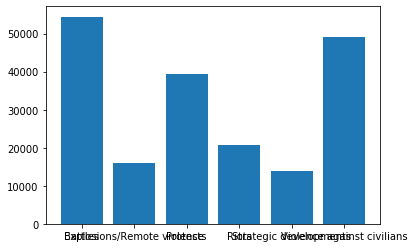

In [41]:
event_type = df.groupby(['EVENT_TYPE'])['EVENT_TYPE'].count()
x = event_type.index
y = event_type.values

plt.bar(x, y)

In [ ]:
# Plotting time series
# https://www.kaggle.com/lordkada/acled-simple-analysis

event_type = df.groupby(['EVENT_DATE'])['EVENT_TYPE'].count()
event_type.plot(subplots=True, figsize=(20, 10), style='.', alpha=0.5)

In [ ]:
year = df.groupby(['YEAR'])['EVENT_TYPE'].count()
year.plot(kind='bar', color = 'gray', figsize=(20, 10))

In [ ]:
country = df.groupby(['COUNTRY'])['EVENT_TYPE'].count()
country.plot(kind='bar', color = 'gray', figsize=(20, 10))